<a href="https://colab.research.google.com/github/GrzegorzPiedel/DataScience-portfolio/blob/main/Payments%20-%20fraud%20detection%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
import os
os.listdir()

Saving creditcard.csv to creditcard.csv


['.config', 'creditcard.csv', 'sample_data']

In [ ]:
# Fraud Detection with Autoencoders
# =================================
# In this project, we use an autoencoder to detect anomalies
# in credit card transaction data. The key idea is that the model
# learns to reconstruct only normal transactions, while anomalies
# (frauds) will have a higher reconstruction error

## 1. Import libraries
import keras
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Reproducibility settings
keras.utils.set_random_seed(43)
tf.config.experimental.enable_op_determinism()

# 1. Load the dataset
df = pd.read_csv('creditcard.csv')

X = df.drop(["Time", "Class"], axis=1).values
y = df["Class"].values

# 2. Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use only normal transactions (Class=0) for training the autoencoder
X_train = X_scaled[y==0]
X_test = X_scaled

# 3. Build the autoencoder
# Architecture: Input -> Encoder -> Bottleneck -> Decoder -> Output
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation="relu")(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)

encoded = Dense(encoding_dim, activation="relu")(encoded)

decoded = Dense(32, activation="relu")(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.2)(decoded)

decoded = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate= 1e-3), loss="mse")

# 4. Train the model
# The model learns to reconstruct only normal transactions
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_split=0.1,
                verbose=0
)

In [ ]:
import numpy as np

# 5. Evaluate reconstruction error
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power((X_test - X_test_pred), 2), axis=1)

# Set threshold based on the 95th percentile of normal transactions
threshold = np.percentile(mse[y==0], 95)
y_pred = (mse > threshold).astype(int)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# 6. Metrics
roc_auc = roc_auc_score(y, mse)
cr = classification_report(y, y_pred)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


np.float64(0.9774130644950668)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


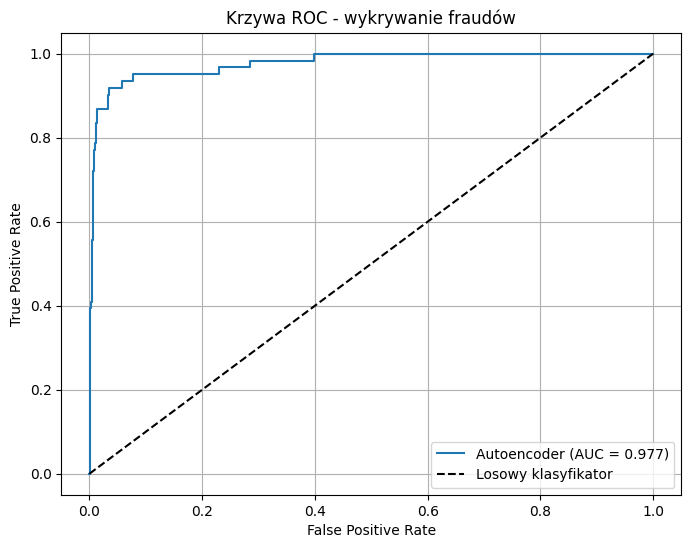

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Oblicz rekonstrukcję (rekonstruowane dane)
X_test_pred = autoencoder.predict(X_test)

# Oblicz błąd rekonstrukcji (mse dla każdego przykładu)
mse = ((X_test - X_test_pred) ** 2).mean(axis=1)

# 7. ROC Curve
fpr, tpr, thresholds = roc_curve(y, mse)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Autoencoder (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Losowy klasyfikator')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Krzywa ROC - wykrywanie fraudów")
plt.legend()
plt.grid(True)
plt.show()